# <font color='gold'>NN Optimization

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import pandas as pd 

# Set options to display max rows / columns in DFs
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('charity_data.csv')
df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


## <font color='lightgreen'>Preprocessing

<font color='gray'>Check *categorical variables* for encoding.  Drop unnecessary columns and implement bucketing strategy.

In [2]:
# Determine the number of unique values in each column.
df.nunique()

EIN                       34299
NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [3]:
# Get columns with unique values under 100
q_cols = df.nunique()[df.nunique() < 100].index
q_cols

Index(['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE',
       'ORGANIZATION', 'STATUS', 'INCOME_AMT', 'SPECIAL_CONSIDERATIONS',
       'IS_SUCCESSFUL'],
      dtype='object')

In [4]:
# Print value counts for columns with unique values under 100
for col in q_cols:
  print(df[col].value_counts())
  print('--------------------')

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64
--------------------
Independent         18480
CompanySponsored    15705
Family/Parent          64
National               33
Regional               13
Other                   4
Name: AFFILIATION, dtype: int64
--------------------
C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
C8000       20
C7120       18
C1500       16
C1800       15
C6000       15
C1250       14
C8200       11
C1238       10
C1278       10
C1235        9
C1237        9
C7210        7
C2400        6
C1720        6
C4

In [5]:
# Drop columns not relevant to analysis ['EIN', 'NAME', 'STATUS', 'SPECIAL_CONSIDERATIONS']
application_df = df.drop(['EIN', 'NAME', 'STATUS', 'SPECIAL_CONSIDERATIONS'], axis=1).copy()

In [6]:
# Create function for bucketing categorical variable values

def bucketing(col, n):
  #create variable for valuecounts and list of values under count of n
  cat_types = application_df[col].value_counts()
  replace_category = list(cat_types[cat_types < n].index)

  # Replace in dataframe
  for app in replace_category:
    application_df[col] = application_df[col].replace(app,"Other")

  return application_df[col].value_counts()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


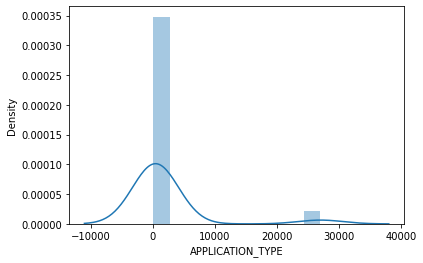

In [7]:
# Visualize the value counts of APPLICATION_TYPE
app_types = application_df.APPLICATION_TYPE.value_counts()

import seaborn as sns
sns.distplot(app_types, bins=10)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


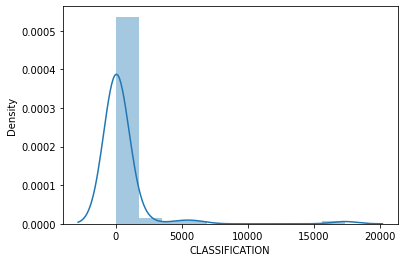

In [8]:
# Visualize the value counts of CLASSIFICATION
class_type = application_df.CLASSIFICATION.value_counts()

sns.distplot(class_type, bins=10)

<font color='gray'>*Bucket* rare events to "Other"

In [9]:
bucketing('APPLICATION_TYPE', 500)

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [10]:
bucketing('CLASSIFICATION', 500)

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
Other     1484
C7000      777
Name: CLASSIFICATION, dtype: int64

In [11]:
bucketing('ORGANIZATION', 500)

Trust          23515
Association    10255
Other            529
Name: ORGANIZATION, dtype: int64

In [12]:
bucketing('USE_CASE', 500)

Preservation    28095
ProductDev       5671
Other             533
Name: USE_CASE, dtype: int64

In [13]:
bucketing('AFFILIATION', 100)

Independent         18480
CompanySponsored    15705
Other                 114
Name: AFFILIATION, dtype: int64

<font color='gray'>Encode categorical variables

In [14]:
application_df.dtypes

APPLICATION_TYPE    object
AFFILIATION         object
CLASSIFICATION      object
USE_CASE            object
ORGANIZATION        object
INCOME_AMT          object
ASK_AMT              int64
IS_SUCCESSFUL        int64
dtype: object

In [15]:
# Generate our categorical variable lists
cat_vars = application_df.dtypes[application_df.dtypes == 'object'].index
cat_vars

Index(['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE',
       'ORGANIZATION', 'INCOME_AMT'],
      dtype='object')

In [16]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[cat_vars]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(cat_vars)
encode_df.head(2)

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Independent,AFFILIATION_Other,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_C7000,CLASSIFICATION_Other,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Other,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Merge one-hot encoded features and drop the originals
prepped_df = application_df.merge(encode_df, left_index=True, right_index=True)
prepped_df = prepped_df.drop(cat_vars, axis=1)
prepped_df.head(2)

,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Independent,AFFILIATION_Other,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_C7000,CLASSIFICATION_Other,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Other,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <font color='lightgreen'>Build Neural Network Model

In [18]:
# Split our preprocessed data into our features and target arrays
X = prepped_df.drop('IS_SUCCESSFUL', axis=1).values
y = prepped_df.IS_SUCCESSFUL.values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [20]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
n_features = len(X_train_scaled[0])
units_layer1 = 24
units_layer2 = 12

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=units_layer1, input_dim=n_features, activation='relu')
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=units_layer2, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                864       
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 1,177
Trainable params: 1,177
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"    

In [22]:
# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

In [24]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5761 - accuracy: 0.7171
Epoch 2/100
804/804 [==============================] - 3s 3ms/step - loss: 0.5554 - accuracy: 0.7269
Epoch 3/100
804/804 [==============================] - 4s 4ms/step - loss: 0.5524 - accuracy: 0.7288
Epoch 4/100
804/804 [==============================] - 4s 5ms/step - loss: 0.5504 - accuracy: 0.7287
Epoch 5/100
800/804 [============================>.] - ETA: 0s - loss: 0.5497 - accuracy: 0.7305
Epoch 5: saving model to checkpoints/weights.05.hdf5
804/804 [==============================] - 3s 4ms/step - loss: 0.5495 - accuracy: 0.7306
Epoch 6/100
804/804 [==============================] - 4s 5ms/step - loss: 0.5486 - accuracy: 0.7313
Epoch 7/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5478 - accuracy: 0.7302
Epoch 8/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5471 - accuracy: 0.7330
Epoch 9/100
804/804 [==============================] -

In [25]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5552 - accuracy: 0.7262 - 491ms/epoch - 2ms/step
Loss: 0.5551757216453552, Accuracy: 0.7261807322502136


In [26]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity.h5")

<font color='gray'>Optimization Actions:
1. Dropped two columns that are heavily imbalanced in their value counts: ['STATUS', 'SPECIAL_CONSIDERATIONS']
2. Bucketed three additional categories: ['ORGANIZATION','USE_CASE','AFFILIATION']
2. Increased Hidden Layer count to 2.
3. Adjusted Neuron count for both layers.
4. Re established activation function for output layer as 'sigmoid'
5. Increase epochs hyperparameter to 100

<font color='gray'>Slight decrease in performance